# Manually use T4 GPU, actually it didn't work so had to use cpu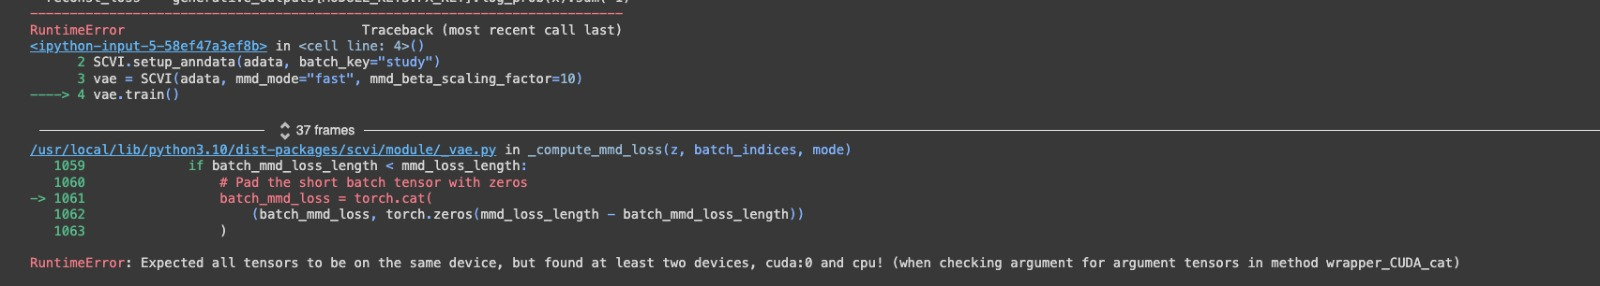

In [52]:
!pip install "scvi-tools @ git+https://github.com/noamgal/scvi-tools@mmd-noamgal"
!pip install scanpy
!pip install igraph
!pip install leidenalg

  Cloning https://github.com/noamgal/scvi-tools (to revision mmd-noamgal) to /tmp/pip-install-r80muc2i/scvi-tools_d3bdc46a8c114c5c9d99cca97af931b1
  Running command git clone --filter=blob:none --quiet https://github.com/noamgal/scvi-tools /tmp/pip-install-r80muc2i/scvi-tools_d3bdc46a8c114c5c9d99cca97af931b1
  Running command git checkout -b mmd-noamgal --track origin/mmd-noamgal
  Switched to a new branch 'mmd-noamgal'
  Branch 'mmd-noamgal' set up to track remote branch 'mmd-noamgal' from 'origin'.
  Resolved https://github.com/noamgal/scvi-tools to commit dc56b67cc787c45f80f84e92e4aea8d5aa499c15
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 8. Loading Pancreas dataset

In [53]:
import anndata
import gdown
import scanpy as sc

url = "https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd"
output = "pancreas.h5ad"
gdown.download(url, output, quiet=False)
adata_all = anndata.read_h5ad("pancreas.h5ad")
adata = adata_all.raw.to_adata()

Downloading...
From (original): https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd
From (redirected): https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd&confirm=t&uuid=1c9f4037-a0e8-46f6-91ec-94531d498585
To: /content/pancreas.h5ad

  0%|          | 0.00/126M [00:00<?, ?B/s]
  4%|▎         | 4.72M/126M [00:00<00:04, 25.9MB/s]
  7%|▋         | 8.91M/126M [00:00<00:05, 20.6MB/s]
 14%|█▎        | 17.3M/126M [00:00<00:04, 26.9MB/s]
 19%|█▊        | 23.6M/126M [00:00<00:02, 34.7MB/s]
 22%|██▏       | 27.8M/126M [00:00<00:03, 30.4MB/s]
 27%|██▋       | 34.1M/126M [00:01<00:02, 31.2MB/s]
 34%|███▎      | 42.5M/126M [00:01<00:02, 33.7MB/s]
 40%|████      | 50.9M/126M [00:01<00:02, 34.9MB/s]
 47%|████▋     | 59.2M/126M [00:01<00:01, 35.0MB/s]
 54%|█████▎    | 67.6M/126M [00:02<00:01, 35.8MB/s]
 60%|██████    | 76.0M/126M [00:02<00:01, 38.5MB/s]
 67%|██████▋   | 84.4M/126M [00:02<00:01, 38.0MB/s]
 73%|███████▎  | 92.8M/126M [00:02<00:00, 39.9MB/s]
 80%|████████  | 101

In [54]:
adata

AnnData object with n_obs × n_vars = 15681 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [55]:
import scvi
import torch
import seaborn as sns
import os
import tempfile
import time
from scvi.model import SCVI

In [56]:
# Just a test run with 20 epochs
# vae.train(max_epochs=20)


In [57]:
def show_visualization_with_and_without_correction(mmd_mode, beta):
    # run PCA then generate UMAP plots
    latent = vae.get_latent_representation()
    adata.obsm[SCVI_LATENT_KEY] = latent
    latent.shape
    msg = f"Visualization with batch correction (scVI), {beta = } {mmd_mode = }"
    print()
    print(msg)
    print("=" * len(msg))
    print()
    sc.tl.pca(adata)
    sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
    sc.tl.umap(adata, min_dist=0.3)

    sc.pl.umap(
        adata,
        color=["cell_type"],
        frameon=False,
    )

    sc.pl.umap(
        adata,
        color=["cell_type", "study"],  # study', 'cell_type', 'size_factors
        ncols=2,
        frameon=False,
    )

    # use scVI latent space for UMAP generation
    msg = f"Visualization with batch correction (scVI), {beta = } {mmd_mode = }"
    print()
    print(msg)
    print("=" * len(msg))
    print()
    sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
    sc.tl.umap(adata, min_dist=0.3)

    sc.pl.umap(
        adata,
        color=["cell_type"],
        frameon=False,
    )
    sc.pl.umap(
        adata,
        color=["cell_type", "study"],
        ncols=2,
        frameon=False,
    )

    # neighbors were already computed using scVI
    msg = f"Clustering on the scVI latent space, {beta = } {mmd_mode = }"
    print()
    print(msg)
    print("=" * len(msg))
    print()
    SCVI_CLUSTERS_KEY = "leiden_scVI"
    sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)
    sc.pl.umap(
        adata,
        color=[SCVI_CLUSTERS_KEY],
        frameon=False,
    )


# 8-10: Train the model with the dataset, show visualizations and compare results

In [ ]:
SCVI_LATENT_KEY = "X_scVI"
timeit_mmd: dict[str, list[float]] = {"fast": [], "normal": []}

for mmd_mode in ("fast", "normal"):
  for beta in (0.1, 1.0, 10.0, 100.0):
    # Init the data and VAE model
    SCVI.setup_anndata(adata, batch_key="study")
    vae = SCVI(adata, mmd_mode=mmd_mode, mmd_beta_scaling_factor=beta)
    print(vae)
    start_time = time.perf_counter()
    vae.train()
    end_time = time.perf_counter()
    timeit_mmd[mmd_mode].append(end_time - start_time)
    print(vae)
    show_visualization_with_and_without_correction(mmd_mode, beta)

print()
print()
print("Performance:")

for mmd_mode, training_time_list in timeit_mmd.items():
  avg_time = sum(training_time_list) / 4
  print(f"For {mmd_mode} MMD: {avg_time:.2f} seconds")


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs



Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)
/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 2/400:   0%|          | 1/400 [00:11<1:15:47, 11.40s/it, v_num=1, train_loss_step=855, train_loss_epoch=952]

/usr/local/lib/python3.10/dist-packages/scvi/module/_vae.py:565: UserWarning: The value argument must be within the support of the distribution
  reconst_loss = -generative_outputs[MODULE_KEYS.PX_KEY].log_prob(x).sum(-1)


Epoch 101/400:  25%|██▌       | 100/400 [12:35<35:19,  7.07s/it, v_num=1, train_loss_step=568, train_loss_epoch=661]